In [1]:
import sys
import onnx
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torchvision import transforms
from PIL import Image

sys.path.append("../misc")
from utils import load_class_label, extract_cifar, unpickle, fuse_single_conv_bn_pair
import torch.nn as nn
from utils import DataShaper, count_parameters
import os
import math
import numpy as np
from numpy import load
import numpy

torch.manual_seed(0)
import resnet_projected as res
import time
from brevitas.nn import QuantConv2d, QuantIdentity, QuantReLU
from brevitas.quant.fixed_point import (
    Int8ActPerTensorFixedPoint,
    Int8WeightPerTensorFixedPoint,
    Uint8ActPerTensorFixedPoint,
)
from brevitas.graph.target.flexml import preprocess_for_flexml_quantize
from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model
import torch.utils.data as data_utils
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate_bn
from brevitas_examples.imagenet_classification.utils import generate_dataloader
from brevitas_examples.imagenet_classification.utils import SEED
from brevitas_examples.imagenet_classification.utils import validate

ds = DataShaper()  # reshape data to match AIE layout

# LOAD THE GOLDEN MODEL
num_classes = 10
offload_model = res.Resnet50(num_classes)
weights = "../misc/weights_resnet50/weights.tar"
saved_model_dict = torch.load(weights, map_location=torch.device("cpu"))
offload_model.load_state_dict(saved_model_dict)

data_dir = "data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor(),
    ]
)
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, transform=transform_train, download=False
)
test_dataset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, transform=transform_test, download=False
)

# Data loader
indices = torch.arange(256)
tr_sub = data_utils.Subset(train_dataset, indices)
val_sub = data_utils.Subset(test_dataset, indices)
calib_loader = torch.utils.data.DataLoader(dataset=tr_sub, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_sub, batch_size=64, shuffle=False)

img_shape = 32
model_aie = preprocess_for_flexml_quantize(
    offload_model.aie,
    torch.ones(1, 64, img_shape, img_shape),
    equalize_iters=1000,
    equalize_merge_bias=True,
    merge_bn=True,
)

quant_model = quantize_model(
    model_aie,
    backend="flexml",
    scale_factor_type="po2_scale",
    bias_bit_width=32,
    weight_bit_width=8,
    weight_narrow_range=False,
    weight_param_method="stats",
    weight_quant_granularity="per_tensor",
    weight_quant_type="sym",
    layerwise_first_last_bit_width=8,
    act_bit_width=8,
    act_param_method="stats",
    act_quant_percentile=99.999,
    act_quant_type="sym",
    quant_format="int",
    layerwise_first_last_mantissa_bit_width=4,
    layerwise_first_last_exponent_bit_width=3,
    weight_mantissa_bit_width=4,
    weight_exponent_bit_width=3,
    act_mantissa_bit_width=4,
    act_exponent_bit_width=3,
)

offload_model.aie = quant_model
offload_model.eval()
print("Starting post training quantization:")
calibrate(calib_loader, offload_model)
offload_model.eval()

# Validate the quant_model on the validation dataloader
# print("Starting validation:")
# validate(val_loader, offload_model)
device, dtype = (
    next(offload_model.parameters()).device,
    next(offload_model.parameters()).dtype,
)
ref_input = torch.ones(1, 3, 32, 32, device=device, dtype=dtype)

Starting post training quantization:


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\gagan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:1271: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/core/TensorImpl.h:1791.)
  return super().rename(names)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:18<00:00, 19.61s/it]


In [2]:
# extract scale and int weight for AIE
print("Setting up SRS with proper scale factor")
from numpy import load

params = {}
weights = {}
for name, module in offload_model.named_modules():
    if isinstance(module, QuantConv2d):
        # print(name)
        # print(module.quant_weight().scale)
        weights[name + ".int_weight"] = module.quant_weight().int(float_datatype=False)
        params[name + "_scale"] = module.quant_weight().scale.detach().numpy()
    if isinstance(module, QuantIdentity):
        # print(name)
        # print(module.quant_act_scale())
        params[name + "_scale"] = module.quant_act_scale()
    if isinstance(module, QuantReLU):
        # print(name)
        # print(module.quant_act_scale())
        params[name + "_scale"] = module.quant_act_scale()
numpy.savez(os.path.join(os.getcwd(), "int_weights.npz"), **weights)
numpy.savez(os.path.join(os.getcwd(), "int_conv_scale.npz"), **params)
int_wts_data = load("int_weights.npz", allow_pickle=True)
int_scale_data = load("int_conv_scale.npz", allow_pickle=True)

design = "bottleneck_init_conv_FINAL_cifar_complete_split_ui8_scalar"
int_wts_data_lst = int_wts_data.files

block_0_int_weight_1 = torch.from_numpy(int_wts_data["aie.layer1.conv1.int_weight"])
block_0_int_weight_2 = torch.from_numpy(int_wts_data["aie.layer1.conv2.int_weight"])
block_0_int_weight_3 = torch.from_numpy(int_wts_data["aie.layer1.conv3.int_weight"])
block_0_int_weights_skip = torch.from_numpy(
    int_wts_data["aie.layer1.shortcut.0.int_weight"]
)

block_1_int_weight_1 = torch.from_numpy(int_wts_data["aie.layer2.conv1.int_weight"])
block_1_int_weight_2 = torch.from_numpy(int_wts_data["aie.layer2.conv2.int_weight"])
block_1_int_weight_3 = torch.from_numpy(int_wts_data["aie.layer2.conv3.int_weight"])

block_2_int_weight_1 = torch.from_numpy(int_wts_data["aie.layer3.conv1.int_weight"])
block_2_int_weight_2 = torch.from_numpy(int_wts_data["aie.layer3.conv2.int_weight"])
block_2_int_weight_3 = torch.from_numpy(int_wts_data["aie.layer3.conv3.int_weight"])

int_scale_data_lst = int_scale_data.files

init_scale = int_scale_data["aie.x_quant_scale"]
block_0_relu_1 = int_scale_data["aie.layer1.relu1_scale"]
block_0_relu_2 = int_scale_data["aie.layer1.relu2_scale"]
block_0_relu_3 = int_scale_data["aie.layer1.relu3_scale"]
block_0_add_scale = int_scale_data["aie.add_quant_scale"]

block_0_weight_scale_1 = int_scale_data["aie.layer1.conv1_scale"]
block_0_weight_scale_2 = int_scale_data["aie.layer1.conv2_scale"]
block_0_weight_scale_3 = int_scale_data["aie.layer1.conv3_scale"]
block_0_weight_scale_skip = int_scale_data["aie.layer1.shortcut.0_scale"]

block_1_relu_1 = int_scale_data["aie.layer2.relu1_scale"]
block_1_relu_2 = int_scale_data["aie.layer2.relu2_scale"]
block_1_relu_3 = int_scale_data["aie.layer2.relu3_scale"]
block_1_add_scale = int_scale_data["aie.add_1_quant_scale"]

block_1_weight_scale_1 = int_scale_data["aie.layer2.conv1_scale"]
block_1_weight_scale_2 = int_scale_data["aie.layer2.conv2_scale"]
block_1_weight_scale_3 = int_scale_data["aie.layer2.conv3_scale"]

block_2_relu_1 = int_scale_data["aie.layer3.relu1_scale"]
block_2_relu_2 = int_scale_data["aie.layer3.relu2_scale"]
block_2_relu_3 = int_scale_data["aie.layer3.relu3_scale"]
block_2_add_scale = int_scale_data["aie.add_2_quant_scale"]

block_2_weight_scale_1 = int_scale_data["aie.layer3.conv1_scale"]
block_2_weight_scale_2 = int_scale_data["aie.layer3.conv2_scale"]
block_2_weight_scale_3 = int_scale_data["aie.layer3.conv3_scale"]

print("_________POST PTQ SCALES_________")
for name, module in offload_model.named_modules():
    if isinstance(module, QuantIdentity):
        print("{}:{}".format(name, module.quant_act_scale()))
for name, module in offload_model.named_modules():
    if isinstance(module, QuantReLU):
        print("{}:{}".format(name, module.quant_act_scale()))
for name, module in offload_model.named_modules():
    if isinstance(module, QuantConv2d):
        print("{}:{}".format(name, module.quant_weight().scale))

from brevitas.export import export_onnx_qcdq

input = torch.randn(1, 64, 32, 32)


# ref_input = torch.ones(1, 3, 32, 32, device="cpu", dtype=dtype)
def Average(lst):
    return sum(lst) / len(lst)


print(offload_model.aie.graph)

for name, param in offload_model.named_parameters():
    if name.endswith(".bias"):
        param.data.fill_(0)

block_0_combined_scale1 = -math.log(
    init_scale * block_0_weight_scale_1 / block_0_relu_1, 2
)  # after conv1x1
block_0_combined_scale2 = -math.log(
    block_0_relu_1 * block_0_weight_scale_2 / block_0_relu_2, 2
)  # after conv3x3
block_0_combined_scale3 = -math.log(
    block_0_relu_2 * block_0_weight_scale_3 / block_0_add_scale, 2
)  # after conv1x1
block_0_combined_scale4 = -math.log(
    block_0_add_scale / block_0_relu_3, 2
)  # after skip addition using init scale
# combined_scale4=-math.log(inp_scale1/inp_scale4)
block_0_combined_scale_skip = -math.log(
    init_scale * block_0_weight_scale_skip / block_0_add_scale, 2
)  # after LHS conv1x1

block_1_combined_scale1 = -math.log(
    block_0_relu_3 * block_1_weight_scale_1 / block_1_relu_1, 2
)  # after conv1x1
block_1_combined_scale2 = -math.log(
    block_1_relu_1 * block_1_weight_scale_2 / block_1_relu_2, 2
)  # after conv3x3
block_1_combined_scale3 = -math.log(
    block_1_relu_2 * block_1_weight_scale_3 / block_1_add_scale, 2
)  # after conv1x1
block_1_combined_scale4 = -math.log(
    block_1_add_scale / block_1_relu_3, 2
)  # after skip addition using init scale

block_2_combined_scale1 = -math.log(
    block_1_relu_3 * block_2_weight_scale_1 / block_2_relu_1, 2
)  # RHS after first conv1x1 | clip 0-->255
block_2_combined_scale2 = -math.log(
    block_2_relu_1 * block_2_weight_scale_2 / block_2_relu_2, 2
)  # RHS after second conv3x3 | clip 0-->255
block_2_combined_scale3 = -math.log(
    block_2_relu_2 * block_2_weight_scale_3 / block_2_add_scale, 2
)  # RHS after third conv1x1 | clip -128-->+127
block_2_combined_scale4 = -math.log(
    block_2_add_scale / block_2_relu_3, 2
)  # After addition | clip 0-->255

print("--------------------------------------------------------------")
print("Block0 combined_scale after first conv1x1:", block_0_combined_scale1)
print("Block0 combined_scale after second conv3x3:", block_0_combined_scale2)
print("Block0 combined_scale after third conv1x1:", block_0_combined_scale3)
print("Block0 combined_scale after adding skip connection:", (block_0_combined_scale4))
print("Block0 combined_scale after skip conv1x1:", block_0_combined_scale_skip)

print("--------------------------------------------------------------")
print("Block1 combined_scale after first conv1x1:", block_1_combined_scale1)
print("Block1 combined_scale after second conv3x3:", block_1_combined_scale2)
print("Block1 combined_scale after third conv1x1:", block_1_combined_scale3)
print("Block1 combined_scale after adding skip connection:", (block_1_combined_scale4))
print("--------------------------------------------------------------")
print("Block2 combined_scale block2 after first conv1x1:", block_2_combined_scale1)
print("Block2 combined_scale block2 after second conv3x3:", block_2_combined_scale2)
print("Block2 combined_scale block2 after third conv1x1:", block_2_combined_scale3)
print(
    "Block2 combined_scale block2 after adding skip connection:",
    (block_2_combined_scale4),
)
print("------------------------------------------------------------------")

Setting up SRS with proper scale factor
_________POST PTQ SCALES_________
aie.x_quant:0.0625
aie.add_quant:0.015625
aie.add_1_quant:0.015625
aie.add_2_quant:0.015625
aie.layer1.relu1:0.015625
aie.layer1.relu2:0.0078125
aie.layer1.relu3:0.015625
aie.layer2.relu1:0.0078125
aie.layer2.relu2:0.00390625
aie.layer2.relu3:0.015625
aie.layer3.relu1:0.0078125
aie.layer3.relu2:0.00390625
aie.layer3.relu3:0.015625
aie.layer1.conv1:0.0009765625
aie.layer1.conv2:0.0009765625
aie.layer1.conv3:0.0009765625
aie.layer1.shortcut.0:0.001953125
aie.layer2.conv1:0.0009765625
aie.layer2.conv2:0.0009765625
aie.layer2.conv3:0.0009765625
aie.layer3.conv1:0.0009765625
aie.layer3.conv2:0.0009765625
aie.layer3.conv3:0.0009765625
graph():
    %x : [#users=1] = placeholder[target=x]
    %x_quant : [#users=2] = call_module[target=x_quant](args = (%x,), kwargs = {})
    %layer1_conv1 : [#users=1] = call_module[target=layer1.conv1](args = (%x_quant,), kwargs = {})
    %layer1_relu1 : [#users=1] = call_module[target=la

In [3]:
print("Setting up AIE")
dtype_in = np.dtype("int8")
dtype_wts = np.dtype("int8")
dtype_out = np.dtype("uint8")

shape_in_act = (32, 8, 32, 8)  #'YCXC8' , 'CYX'
shape_total_wts = (212992, 1)
shape_out = (32, 32, 32, 8)
trace_size = 8192

block_0_wts1 = ds.reorder_mat(
    block_0_int_weight_1.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block_0_wts2 = ds.reorder_mat(
    block_0_int_weight_2.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block_0_wts3 = ds.reorder_mat(
    block_0_int_weight_3.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block_0_wts_skip = ds.reorder_mat(
    block_0_int_weights_skip.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
total_wts = np.concatenate(
    (block_0_wts1, block_0_wts2, block_0_wts3, block_0_wts_skip), axis=None
)
block1_wts1 = ds.reorder_mat(
    block_1_int_weight_1.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block1_wts2 = ds.reorder_mat(
    block_1_int_weight_2.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block1_wts3 = ds.reorder_mat(
    block_1_int_weight_3.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
total_wts2 = np.concatenate(
    (total_wts, block1_wts1, block1_wts2, block1_wts3), axis=None
)
block2_wts1 = ds.reorder_mat(
    block_2_int_weight_1.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block2_wts2 = ds.reorder_mat(
    block_2_int_weight_2.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
block2_wts3 = ds.reorder_mat(
    block_2_int_weight_3.data.numpy().astype(dtype_wts), "OIYXI8O8", "OIYX"
)
total_wts3 = np.concatenate(
    (total_wts2, block2_wts1, block2_wts2, block2_wts3), axis=None
)

design = "layer_1"
log_folder = "log/log_DEMO_" + design
if not os.path.exists(log_folder):
    os.makedirs(log_folder)
sys.path.append("../../../utils")
import xrtutils

xclbin_path = os.path.abspath("../network/" + design + "/build/final.xclbin")
insts_path = os.path.abspath("../network/" + design + "/build/insts.txt")

cifar_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

enable_aie = True
aie_is_setup = False
app = None
in_buf = None
arg1_buf = None
out_buf = None


trace_size = 8192


def setup_aie(
    xclbin_path,
    insts_path,
    in_0_shape,
    in_0_dtype,
    in_1_shape,
    in_1_dtype,
    out_buf_shape,
    out_buf_dtype,
    enable_trace=False,
    kernel_name="MLIR_AIE",
):
    app = xrtutils.AIE_Application(xclbin_path, insts_path, kernel_name)
    app.register_buffer(2, shape=in_0_shape, dtype=in_0_dtype)
    app.register_buffer(3, shape=in_1_shape, dtype=in_1_dtype)
    if enable_trace:
        out_buf_len_bytes = np.prod(out_buf_shape) * np.dtype(out_buf_dtype).itemsize
        out_buf_shape = (out_buf_len_bytes + trace_size,)
        out_buf_dtype = np.uint8
    app.register_buffer(4, shape=out_buf_shape, dtype=out_buf_dtype)
    return app


def extract_trace(out_buf, out_buf_shape, out_buf_dtype):
    trace_size_words = trace_size // 4
    out_buf_flat = out_buf.reshape((-1,)).view(np.uint32)
    output_prefix = (
        out_buf_flat[:-trace_size_words].view(out_buf_dtype).reshape(out_buf_shape)
    )
    trace_suffix = out_buf_flat[-trace_size_words:]
    return output_prefix, trace_suffix


def write_out_trace(trace, file_name):
    out_str = "\n".join(f"{i:0{8}x}" for i in trace if i != 0)
    with open(file_name, "w") as f:
        f.write(out_str)


app = setup_aie(
    xclbin_path,
    insts_path,
    shape_in_act,
    dtype_in,
    shape_total_wts,
    dtype_wts,
    shape_out,
    dtype_out,
)


def run_on_aie(ticks, app):
    tick = time.perf_counter()
    app.run()
    tock = time.perf_counter()
    ticks.extend([tick, tock])


ticks = []

Setting up AIE


____________________________________IMAGE 0____________________________________________
 Predicted AIE: cat, Predicted CPU: cat
____________________________________IMAGE 1____________________________________________
 Predicted AIE: ship, Predicted CPU: ship
____________________________________IMAGE 2____________________________________________
 Predicted AIE: ship, Predicted CPU: ship
____________________________________IMAGE 3____________________________________________
 Predicted AIE: ship, Predicted CPU: ship
____________________________________IMAGE 4____________________________________________
 Predicted AIE: frog, Predicted CPU: frog
____________________________________IMAGE 5____________________________________________
 Predicted AIE: deer, Predicted CPU: deer
____________________________________IMAGE 6____________________________________________
 Predicted AIE: automobile, Predicted CPU: automobile
____________________________________IMAGE 7_____________________________________

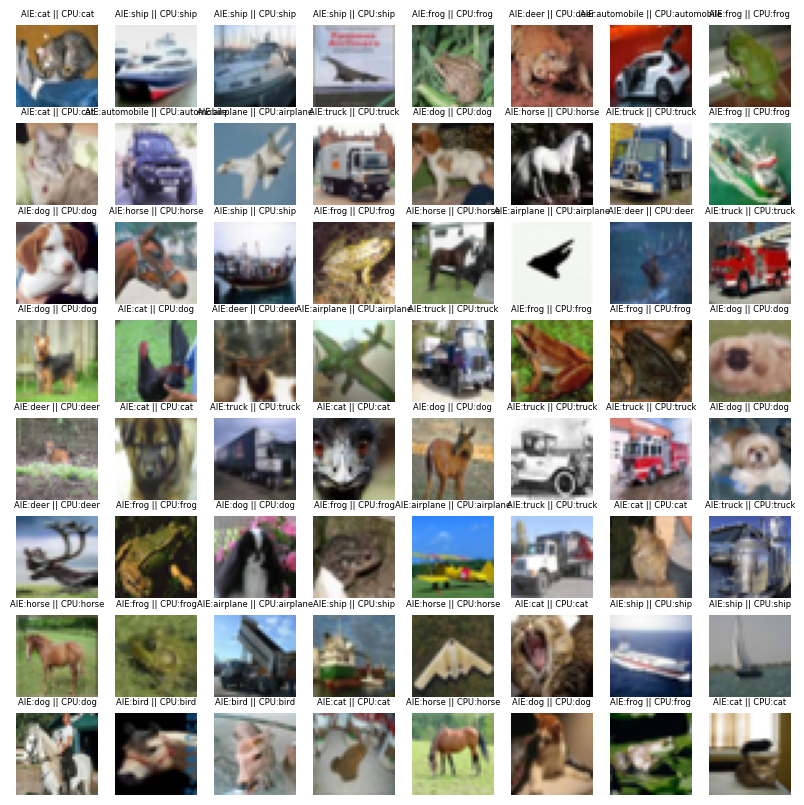

In [5]:
import numpy as np
import time

predicted_label = [None] * 64
cpu_predicted_label = [None] * 64
aie_time = [None] * 64
metafile = r"./data/cifar-10-batches-py/batches.meta"
datafile = r"./data/cifar-10-batches-py/test_batch"
data_batch_1 = unpickle(datafile)
metadata = unpickle(metafile)
labels = data_batch_1["labels"]
label_path = "data/cifar10_label_map.txt"
model_num_classes = 10
class_label_map = load_class_label(label_path, model_num_classes)
quant_id_1 = QuantIdentity(
    act_quant=Uint8ActPerTensorFixedPoint, bit_width=8, return_quant_tensor=True
)
quant_id_1.eval()
for i in range(0, 64):
    print(
        "____________________________________IMAGE {}____________________________________________".format(
            i
        )
    )
    image_name = f"./cifar_images/image_{i}.png"
    img = Image.open(image_name)
    input_tensor = cifar_test_transform(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        # print(input_batch.shape
        start = time.time() * 1000
        output1 = offload_model.first(input_batch)

        # AIE OFFLOAD
        qnt_inp = offload_model.aie.x_quant(output1)
        int_inp = offload_model.aie.x_quant(output1).int(float_datatype=True)
        before_input = int_inp.squeeze().data.numpy().astype(dtype_in)
        ifm_mem_fmt = ds.reorder_mat(before_input, "YCXC8", "CYX")
        app.buffers[2].write(ifm_mem_fmt)  # input's standard format CYX | scalar YCX
        app.buffers[3].write(total_wts3)  # wts's standard format OIYX | scalar OIYX
        app.run()
        output_aie = app.buffers[4].read() * block_2_relu_3
        temp_out = output_aie.reshape(32, 32, 32, 8)
        temp2_out = ds.reorder_mat(temp_out, "CDYX", "YCXD")
        ofm_mem_fmt = temp2_out.reshape(256, 32, 32)
        ofm_mem_fmt = torch.from_numpy(ofm_mem_fmt).unsqueeze(0)
        final_output_aie = offload_model.post(ofm_mem_fmt)

        # ------------------------------------------------------------------------------
        # Baseline output for functional correctness
        output_golden = offload_model.aie(output1)
        max_error = torch.max(torch.abs(ofm_mem_fmt - output_golden))
        # print(max_error)
        final_output_base = offload_model.post(output_golden)
        predicted_class = np.argmax(final_output_aie)
        predicted_label[i] = metadata["label_names"][predicted_class]
        cpu_predicted_class = np.argmax(final_output_base)
        cpu_predicted_label[i] = metadata["label_names"][cpu_predicted_class]
        label = metadata["label_names"][labels[i]]
        print(
            f" Predicted AIE: {predicted_label[i]}, Predicted CPU: {cpu_predicted_label[i]}"
        )

        # Calculate the five categories with the highest classification probability
        prediction_class_index = (
            torch.topk(final_output_aie, k=5, sorted=True).indices.squeeze(0).tolist()
        )
        golden_prediction_class_index = (
            torch.topk(final_output_base, k=5, sorted=True).indices.squeeze(0).tolist()
        )

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    img = Image.open("./cifar_images/image_" + str(i) + ".png")
    ax.imshow(img)
    ax.axis("off")  # to hide the axes
    ax.set_title(
        "AIE:" + predicted_label[i] + " || CPU:" + cpu_predicted_label[i], fontsize=6
    )